# Logistic Regression

Topics covered:

* Logistic Regression
* Resampling Methods
* Subset Selection
* Shrinkage Methods
* Dimensionality Reduction

## Background
The study of Near-Earth Objects (NEOs) is critical to ensuring future planetary security from impacts by asteroids. Predicting potential impacts may seem as if it is a straightforward task but the number of variables involved in the process leads to quite a bit of uncertainty. Because of this, the Center for NEO Studies (https://cneos.jpl.nasa.gov/about/cneos.html) and NASA's Jet Propulsion Laboratory has been logging data about asteroids and whether they meet the classification of hazardous or not. The data is provided on Canvas.

### Dataset
`nasa.csv`

## Task
Your goal is to construct a model that effectively predicts whether an asteroid is hazardous or not. Ideally, you will find a relatively simple (i.e. interpretable) model, such that we don't need to collect every variable below to make a prediction (hint: subset selection and/or shrinkage would be useful for this). The fewer variables we have to collect, the more asteroids we'll be able to observe. I would also like you to utilize PCA to select some number of principal components and try a logistic regression with those as predictor variables.

I'm looking for a well-constructed logistic regression, whose assumptions have been checked, with strong cross-validated accuracy and an interpretation of the coefficients. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import time
import itertools
from scipy.special import binom
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error
plt.style.use('seaborn-white')

In [2]:
# read in data, and view
df = pd.read_csv('nasa.csv')
print(df.shape)
df.head()

(4687, 40)


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [3]:
df = df.dropna()
# eliminate columns that are repetitive
df = df.drop(['Miss Dist.(kilometers)','Est Dia in KM(min)','Est Dia in KM(max)','Est Dia in M(min)','Est Dia in M(max)','Est Dia in Feet(min)','Est Dia in Feet(max)'], axis=1)
df.shape

(4687, 33)

In [4]:
X = df.drop(['Name','Neo Reference ID','Orbit Determination Date','Close Approach Date'], axis=1)
y = df[['Hazardous']]
df['Hazardous'] = (df['Hazardous'] == 'TRUE').astype(int)
X.head()

,Absolute Magnitude,Est Dia in Miles(min),Est Dia in Miles(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(miles),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,21.6,0.079051,0.176763,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,38993336.0,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,21.3,0.090762,0.202951,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,35603420.0,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,20.3,0.143849,0.321655,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,4736657.5,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,27.4,0.005469,0.012229,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,26522368.0,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,21.6,0.079051,0.176763,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,37910368.0,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [5]:
X[['Absolute Magnitude', 'Est Dia in Miles(min)',
       'Est Dia in Miles(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(miles)', 'Orbit ID',
       'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']] = (X[['Absolute Magnitude', 'Est Dia in Miles(min)',
       'Est Dia in Miles(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(miles)', 'Orbit ID',
       'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']]-X[['Absolute Magnitude', 'Est Dia in Miles(min)',
       'Est Dia in Miles(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(miles)', 'Orbit ID',
       'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']].mean())/X[['Absolute Magnitude', 'Est Dia in Miles(min)',
       'Est Dia in Miles(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(miles)', 'Orbit ID',
       'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']].std()
X.head()

,Absolute Magnitude,Est Dia in Miles(min),Est Dia in Miles(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(miles),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,-0.231017,-0.209388,-0.209388,-1.972877,-1.077024,-1.077024,-1.077024,1.115956,1.115956,1.115956,...,1.377044,-0.070042,-0.021170,-1.223756,0.019568,0.459141,0.778310,-0.431054,J2000,True
1,-0.334789,-0.158389,-0.158389,-1.972877,0.568085,0.568085,0.568085,0.865829,0.865829,0.865829,...,-0.343156,-0.565333,-0.393225,1.247764,-0.514747,0.070810,-0.069086,0.312548,J2000,False
2,-0.680693,0.072781,0.072781,-1.969825,-0.874798,-0.874798,-0.874798,-1.411692,-1.411692,-1.411692,...,0.845482,0.021561,0.567662,0.622945,-0.021321,0.415535,1.039293,-0.522059,J2000,True
3,1.775228,-0.529807,-0.529807,-1.966773,-0.383498,-0.383498,-0.383498,0.195779,0.195779,0.195779,...,-1.113358,-0.327533,0.704449,-1.596170,-0.482638,0.184520,-1.045816,-0.110806,J2000,False
4,-0.231017,-0.209388,-0.209388,-1.966773,-0.566276,-0.566276,-0.566276,1.036049,1.036049,1.036049,...,-0.847509,-0.377362,0.637461,-0.247974,-0.529260,0.091447,-0.428140,-0.034576,J2000,True


In [6]:
# split data into training, testing, and validation sets
splits = np.random.choice(a=3, size = X.shape[0], p = [.7,.15,.15])

Xtrain = X.iloc[np.where(splits == 0)[0],:]
Xtrain = Xtrain.drop(['Hazardous'], axis=1)
Xval = X.iloc[np.where(splits == 1)[0],:]
Xval = Xval.drop(['Hazardous'], axis=1)
Xtest = X.iloc[np.where(splits == 2)[0],:]
Xtest = Xtest.drop(['Hazardous'], axis=1)

ytrain = y.iloc[np.where(splits == 0)[0],:]
ytrain = ytrain[['Hazardous']]
yval = y.iloc[np.where(splits == 1)[0],:]
yval = yval[['Hazardous']]
ytest = y.iloc[np.where(splits == 2)[0],:]
ytest = ytest[['Hazardous']]

X = X.drop(['Hazardous'], axis=1)

print(X.shape, y.shape)
print(Xtrain.shape, ytrain.shape)
print(Xval.shape, yval.shape)
print(Xtest.shape, ytest.shape)

(4687, 28) (4687, 1)
(3234, 28) (3234, 1)
(694, 28) (694, 1)
(759, 28) (759, 1)


In [7]:
# define Xtrain and ytrain dataframes
Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
Xval = pd.get_dummies(data=Xval, drop_first=True)
Xtest = pd.get_dummies(data=Xtest, drop_first=True)


print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(3234, 26)
(694, 26)
(759, 26)


In [8]:
Xtrain.columns

Index(['Absolute Magnitude', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(miles)',
       'Orbit ID', 'Orbit Uncertainity', 'Minimum Orbit Intersection',
       'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',
       'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion'],
      dtype='object')

# Subset Selection

In [9]:
def processSubset(X, y, predictor_variables, response_variable):
    # Fit model on feature_set and calculate RSS
    
    model = sm.OLS(y,X[list(predictor_variables)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(predictor_variables)]) - y[response_variable]) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [10]:
# define forward stepwise selection function
def forward(X, y, predictors, response_variable):
    
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    t0 = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X, y, predictors + [p], response_variable))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    t1 = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (t1-t0), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [11]:
y

,Hazardous
0,True
1,False
2,True
3,False
4,True
...,...
4682,False
4683,False
4684,False
4685,False


In [12]:
# store model, RSS, and BIC in dataframe
models_fwd = pd.DataFrame(columns=["RSS", "model", "AIC", "BIC", "AdjR2"])

predictors = []

for i in range(1,len(Xtrain.columns)+1):    
    models_fwd.loc[i] = forward(Xtrain, ytrain, predictors, 'Hazardous')
    predictors = models_fwd.loc[i]["model"].model.exog_names
    models_fwd.loc[i, 'AIC'] = models_fwd.loc[i, 'model'].aic
    models_fwd.loc[i, 'BIC'] = models_fwd.loc[i, 'model'].bic
    models_fwd.loc[i, 'AdjR2'] = models_fwd.loc[i, 'model'].rsquared_adj

models_fwd

Processed  26 models on 1 predictors in 0.10497903823852539 seconds.
Processed  25 models on 2 predictors in 0.07664775848388672 seconds.
Processed  24 models on 3 predictors in 0.06199359893798828 seconds.
Processed  23 models on 4 predictors in 0.0698244571685791 seconds.
Processed  22 models on 5 predictors in 0.06927824020385742 seconds.
Processed  21 models on 6 predictors in 0.06496262550354004 seconds.
Processed  20 models on 7 predictors in 0.06295108795166016 seconds.
Processed  19 models on 8 predictors in 0.07446432113647461 seconds.
Processed  18 models on 9 predictors in 0.05900001525878906 seconds.
Processed  17 models on 10 predictors in 0.06000113487243652 seconds.
Processed  16 models on 11 predictors in 0.060060739517211914 seconds.
Processed  15 models on 12 predictors in 0.06788921356201172 seconds.
Processed  14 models on 13 predictors in 0.05774092674255371 seconds.
Processed  13 models on 14 predictors in 0.05544257164001465 seconds.
Processed  12 models on 15 pr

,RSS,model,AIC,BIC,AdjR2
1,463.352167,<statsmodels.regression.linear_model.Regressio...,2896.072352,2902.153827,-462.495486
2,398.335642,<statsmodels.regression.linear_model.Regressio...,2409.116091,2421.279041,-397.582137
3,353.072664,<statsmodels.regression.linear_model.Regressio...,2021.027493,2039.271918,-352.400494
4,347.675340,<statsmodels.regression.linear_model.Regressio...,1973.208469,1997.534369,-347.105898
5,346.754075,<statsmodels.regression.linear_model.Regressio...,1966.627682,1997.035057,-346.291012
6,346.533726,<statsmodels.regression.linear_model.Regressio...,1966.571945,2003.060795,-346.177840
7,346.295448,<statsmodels.regression.linear_model.Regressio...,1966.347473,2008.917799,-346.046631
8,346.084122,<statsmodels.regression.linear_model.Regressio...,1966.373331,2015.025131,-345.942359
9,345.945761,<statsmodels.regression.linear_model.Regressio...,1967.080154,2021.813429,-345.911191
10,345.812697,<statsmodels.regression.linear_model.Regressio...,1967.835993,2028.650743,-345.885317


21


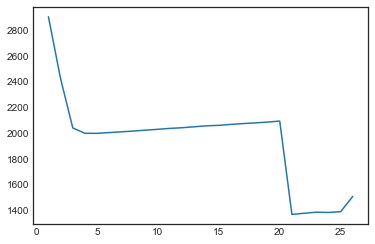

In [13]:
# plot BIC. We use this one because the importance of minimizing variables is exaggerated
# BIC has a stronger punishment term for models with greater complexity.
print(np.argmin(models_fwd['BIC']) + 1)
plt.plot(np.arange(len(models_fwd)) + 1,models_fwd['BIC'])

In [14]:
# view model summary
models_fwd.loc[np.argmin(models_fwd['BIC']) + 1,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Hazardous   R-squared (uncentered):                -273.936
Model:                            OLS   Adj. R-squared (uncentered):           -275.646
Method:                 Least Squares   F-statistic:                             -160.1
Date:                Fri, 08 Jul 2022   Prob (F-statistic):                        1.00
Time:                        22:40:23   Log-Likelihood:                         -603.04
No. Observations:                3234   AIC:                                      1246.
Df Residuals:                    3214   BIC:                                      1368.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Orbit Uncertainity              -0.0560      0.008     -6.901      0.000      -0.072      -0.040
Minimum Orbit Intersection      -0.2157      0.007    -30.261      0.000      -0.230      -0.202
Absolute Magnitude              -0.1980      0.011    -18.633      0.000      -0.219      -0.177
Est Dia in Miles(min)        -3.799e+07   3.88e+07     -0.978      0.328   -1.14e+08    3.81e+07
Jupiter Tisserand Invariant     -0.5050      0.186     -2.720      0.007      -0.869      -0.141
Epoch Date Close Approach        0.0101      0.005      1.866      0.062      -0.001       0.021
Relative Velocity km per sec  1.394e+09   1.31e+09      1.061      0.289   -1.18e+09    3.97e+09
Asc Node Longitude               0.0050      0.005      0.964      0.335      -0.005       0.015
Est Dia in Miles(max)         3.799e+07   3.88e+07      0.978      0.328   -3.81e+07    1.14e+08
Orbit ID                         0.0075      0.008      0.929      0.353      -0.008       0.023
Aphelion Dist                   -0.6301      0.240     -2.625      0.009      -1.101      -0.159
Mean Motion                      0.3426      0.144      2.373      0.018       0.060       0.626
Mean Anomaly                     0.0135      0.006      2.367      0.018       0.002       0.025
Perihelion Time                 -0.0774      0.027     -2.873      0.004      -0.130      -0.025
Epoch Osculation                 0.0743      0.027      2.766      0.006       0.022       0.127
Inclination                     -0.0196      0.012     -1.642      0.101      -0.043       0.004
Orbital Period                   0.4829      0.201      2.400      0.016       0.088       0.877
Eccentricity                     0.0495      0.022      2.213      0.027       0.006       0.093
Perihelion Distance             -0.0710      0.047     -1.503      0.133      -0.164       0.022
Relative Velocity km per hr  -2.174e+13   7.64e+11    -28.471      0.000   -2.32e+13   -2.02e+13
Miles per hour                2.174e+13   7.64e+11     28.469      0.000    2.02e+13    2.32e+13
==============================================================================
Omnibus:                      215.089   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.550
Skew:                           0.693   Prob(JB):                     4.36e-57
Kurtosis:                       2.926   Cond. No.                     4.94e+14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctl

In [15]:
X = pd.get_dummies(data=X, drop_first=True)
X

,Absolute Magnitude,Est Dia in Miles(min),Est Dia in Miles(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(miles),...,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,-0.231017,-0.209388,-0.209388,-1.972877,-1.077024,-1.077024,-1.077024,1.115956,1.115956,1.115956,...,0.012874,-0.671883,1.377044,-0.070042,-0.021170,-1.223756,0.019568,0.459141,0.778310,-0.431054
1,-0.334789,-0.158389,-0.158389,-1.972877,0.568085,0.568085,0.568085,0.865829,0.865829,0.865829,...,-0.558019,1.375168,-0.343156,-0.565333,-0.393225,1.247764,-0.514747,0.070810,-0.069086,0.312548
2,-0.680693,0.072781,0.072781,-1.969825,-0.874798,-0.874798,-0.874798,-1.411692,-1.411692,-1.411692,...,0.111723,-0.835378,0.845482,0.021561,0.567662,0.622945,-0.021321,0.415535,1.039293,-0.522059
3,1.775228,-0.529807,-0.529807,-1.966773,-0.383498,-0.383498,-0.383498,0.195779,0.195779,0.195779,...,-0.275417,-0.499985,-1.113358,-0.327533,0.704449,-1.596170,-0.482638,0.184520,-1.045816,-0.110806
4,-0.231017,-0.209388,-0.209388,-1.966773,-0.566276,-0.566276,-0.566276,1.036049,1.036049,1.036049,...,-0.333202,0.312680,-0.847509,-0.377362,0.637461,-0.247974,-0.529260,0.091447,-0.428140,-0.034576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4682,0.564563,-0.434264,-0.434264,1.480856,1.122063,1.122063,1.122063,-1.477503,-1.477503,-1.477503,...,-0.455658,2.423747,-0.077210,-0.480927,-0.296727,0.893255,-0.426523,-0.021054,1.145453,0.143578
4683,2.051952,-0.537147,-0.537147,1.480856,-1.473376,-1.473376,-1.473376,-1.716820,-1.716820,-1.716820,...,-0.620293,-0.732757,1.675768,-0.615699,0.756224,-1.370080,-0.875767,0.380744,0.947063,0.425755
4684,0.149477,-0.346201,-0.346201,1.480856,-0.929516,-0.929516,-0.929516,-1.342743,-1.342743,-1.342743,...,0.244147,-0.820061,-1.308434,0.146843,0.629504,0.876803,0.108841,0.606180,0.207748,-0.632011
4685,-0.161837,-0.239677,-0.239677,1.480856,-0.359062,-0.359062,-0.359062,0.027308,0.027308,0.027308,...,0.164716,0.704667,-0.080893,0.071346,1.537162,-0.034644,-0.209571,0.593240,0.207969,-0.567601


# Shrinkage Methods

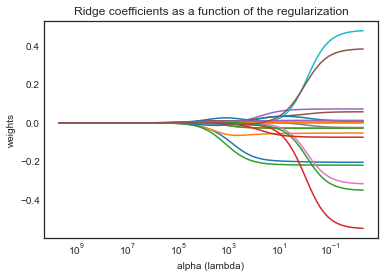

In [16]:
# Ridge Regression
alphas = 10**np.linspace(10,-2,100)*0.5

coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scale(Xtrain), ytrain)
    ridge.coef_ = ridge.coef_[0]
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha (lambda)')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [17]:
scaler = StandardScaler().fit(Xtrain)

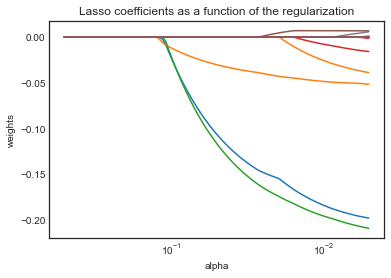

In [20]:
# lasso
alphas = 10**np.linspace(0,-2,100)*0.5

lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [21]:
folds = np.random.choice(a = 10, size = Xtrain.shape[0])
alphas = np.linspace(0.001,.2,100)

mse_list = []
for alpha in alphas:
    cv_list = []
    for i in range(10):
        val_folds_X = Xtrain.iloc[np.where(folds == i)]
        train_folds_X = Xtrain.iloc[np.where(folds != i)]
        
        val_folds_y = ytrain.iloc[np.where(folds == i)]
        train_folds_y = ytrain.iloc[np.where(folds != i)]
        
        lassocv = Lasso(alpha=alpha, max_iter=10000)
        lassocv.fit(scaler.transform(train_folds_X), train_folds_y)
        pred = lassocv.predict(scaler.transform(val_folds_X))
        cv_list.append(mean_squared_error(val_folds_y, pred))
    mse_list.append(np.mean(cv_list))

Text(0, 0.5, 'Cross-validated MSE')

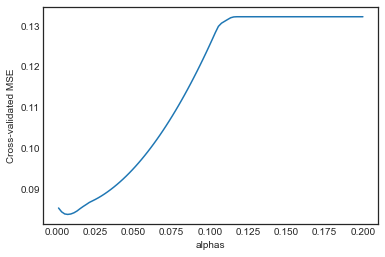

In [22]:
plt.plot(alphas,mse_list)
plt.xlabel('alphas')
plt.ylabel('Cross-validated MSE')

In [23]:
opt_lambda = alphas[np.argmin(mse_list)]
opt_lambda

0.00703030303030303

In [24]:
opt_lasso = Lasso()
opt_lasso.set_params(alpha=opt_lambda, max_iter=10000)
opt_lasso.fit(scaler.transform(Xtrain), ytrain)
mean_squared_error(yval, opt_lasso.predict(scaler.transform(Xval)))

0.08491198144770146

In [25]:
pd.Series(opt_lasso.coef_.flatten(), index=X.columns)

Absolute Magnitude             -0.185185
Est Dia in Miles(min)          -0.034424
Est Dia in Miles(max)          -0.000000
Epoch Date Close Approach       0.000794
Relative Velocity km per sec    0.005749
Relative Velocity km per hr     0.000000
Miles per hour                  0.000000
Miss Dist.(Astronomical)        0.000000
Miss Dist.(lunar)               0.000000
Miss Dist.(miles)               0.000000
Orbit ID                        0.000000
Orbit Uncertainity             -0.049077
Minimum Orbit Intersection     -0.196764
Jupiter Tisserand Invariant    -0.010031
Epoch Osculation               -0.000000
Eccentricity                    0.000064
Semi Major Axis                 0.000000
Inclination                     0.000000
Asc Node Longitude              0.000000
Orbital Period                  0.000000
Perihelion Distance             0.000000
Perihelion Arg                  0.000000
Aphelion Dist                   0.000000
Perihelion Time                -0.000000
Mean Anomaly    

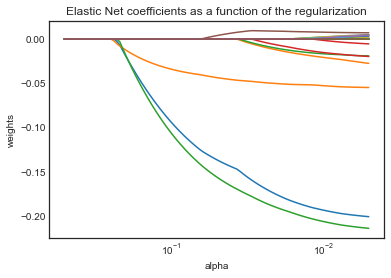

In [26]:
# elastic net for determining shrinkage methods
alphas = 10**np.linspace(0,-2,100)*0.5
l1_ratio = 0.5

en = ElasticNet(max_iter=1000)
coefs = []

for a in alphas:
    en.set_params(alpha=a, l1_ratio=l1_ratio)
    en.fit(scale(X), y)
    coefs.append(en.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net coefficients as a function of the regularization');

In [27]:
# establish and train fields
folds = np.random.choice(a = 10, size = Xtrain.shape[0])
alphas = np.linspace(0.01,1,10)
l1_ratio = np.linspace(0.01,1,10)

mse_list = []
alpha_list = []
l1_list = []
for alpha in alphas:
    for l1 in l1_ratio:
        cv_list = []
        for i in range(10):
            val_folds_X = Xtrain.iloc[np.where(folds == i)]
            train_folds_X = Xtrain.iloc[np.where(folds != i)]

            val_folds_y = ytrain.iloc[np.where(folds == i)]
            train_folds_y = ytrain.iloc[np.where(folds != i)]

            encv = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
            encv.fit(scaler.transform(train_folds_X), train_folds_y)
            pred = encv.predict(scaler.transform(val_folds_X))
            cv_list.append(mean_squared_error(val_folds_y, pred))
        mse_list.append(np.mean(cv_list))
        alpha_list.append(alpha)
        l1_list.append(l1)

<AxesSubplot:xlabel='l1_ratio', ylabel='alpha'>

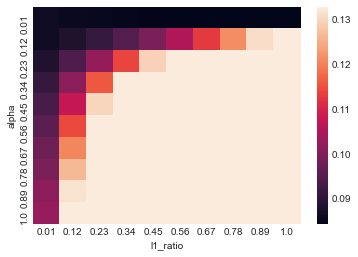

In [28]:
# plot heatmap
plotdata = pd.DataFrame({'alpha': alpha_list, 'l1_ratio': l1_list, 'mse': mse_list})
plot_data_pivoted = plotdata.pivot("alpha", "l1_ratio", "mse")
sns.heatmap(plot_data_pivoted)

In [29]:
opt_lambda = alpha_list[np.argmin(mse_list)]
opt_l1 = l1_list[np.argmin(mse_list)]
print(opt_lambda, opt_l1)

0.01 0.78


In [30]:
# see how these values do on the validation set
opt_en = ElasticNet()
opt_en.set_params(alpha=opt_lambda, l1_ratio=opt_l1, max_iter=10000)
opt_en.fit(scaler.transform(Xtrain), ytrain)
print("MSE for Elastic Net:", mean_squared_error(yval, opt_en.predict(scaler.transform(Xval))))
print("MSE for Lasso:", mean_squared_error(yval, opt_lasso.predict(scaler.transform(Xval))))

MSE for Elastic Net: 0.08529867827690243
MSE for Lasso: 0.08491198144770146


In [31]:
pd.Series(opt_en.coef_.flatten(), index=X.columns)

Absolute Magnitude             -0.181377
Est Dia in Miles(min)          -0.020398
Est Dia in Miles(max)          -0.011639
Epoch Date Close Approach       0.000000
Relative Velocity km per sec    0.002890
Relative Velocity km per hr     0.001851
Miles per hour                  0.000611
Miss Dist.(Astronomical)        0.000000
Miss Dist.(lunar)               0.000000
Miss Dist.(miles)               0.000000
Orbit ID                        0.000000
Orbit Uncertainity             -0.048923
Minimum Orbit Intersection     -0.193888
Jupiter Tisserand Invariant    -0.008751
Epoch Osculation                0.000000
Eccentricity                    0.000703
Semi Major Axis                 0.000000
Inclination                     0.000000
Asc Node Longitude              0.000000
Orbital Period                  0.000000
Perihelion Distance             0.000000
Perihelion Arg                  0.000000
Aphelion Dist                   0.000000
Perihelion Time                -0.000000
Mean Anomaly    

# PCA

In [32]:
Xtrain.shape[1]-1
train = Xtrain
train['Hazardous'] = ytrain
val = Xval
val['Hazardous'] = yval
test = Xtest
test['Hazardous'] = ytest

In [33]:
pca = PCA(n_components=train.shape[1] - 1).fit(train.iloc[:,:-1])
pc_train = pca.transform(train.iloc[:,:-1])

C:\Users\light\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scree Plot')

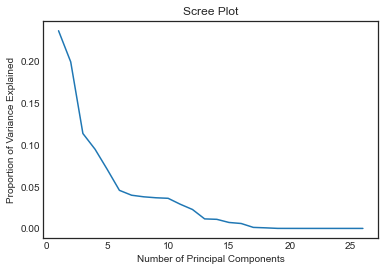

In [34]:
sns.lineplot(np.arange(1,train.shape[1]), pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")

C:\Users\light\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

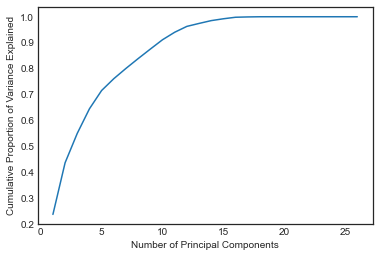

In [35]:
sns.lineplot(np.arange(1,train.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

C:\Users\light\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

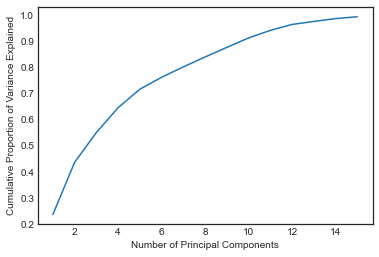

In [36]:
# look closer
sns.lineplot(np.arange(1,16), np.cumsum(pca.explained_variance_ratio_)[:15])
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

C:\Users\light\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

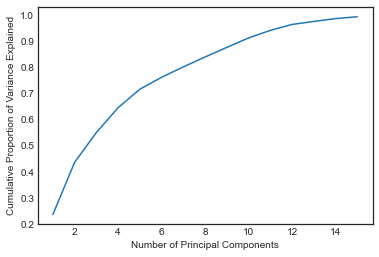

In [37]:
sns.lineplot(np.arange(1,16), np.cumsum(pca.explained_variance_ratio_)[:15])
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

In [38]:
# Move forward with 14 predictor variables.
# Less variables would be great, but we must have high enough accuracy, so 14 makes sense.

In [39]:
Counter(train.iloc[:,-1])

Counter({True: 507, False: 2727})

In [40]:
2738/(537+2738)
# the accuracy mark to hit

0.836030534351145

In [41]:
pc_log_reg = LogisticRegression().fit(pc_train[:,:14],ytrain)

C:\Users\light\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
pc_val = pca.transform(Xval.iloc[:,:-1])
pc_log_reg.score(pc_val[:,:14], yval)
# 14 variables is good enough

0.920749279538905

In [43]:
pc_val = pd.DataFrame(pc_val)
pc_val

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.302740,-1.980189,-0.290633,-1.095088,0.620001,-1.149615,0.043978,-1.557708,-0.929288,0.019594,...,0.140530,0.164746,0.029661,-0.011020,-1.519558e-08,-6.365910e-08,1.556717e-10,5.201299e-12,1.143653e-15,2.082649e-15
1,-2.965631,-0.746399,0.083381,-0.070379,-0.195626,1.074813,-0.341784,-0.594775,-1.441903,-1.388356,...,0.068909,0.039830,0.013077,0.005922,6.555795e-08,-4.692900e-08,-3.345607e-11,4.097297e-12,-1.093715e-15,-1.355348e-15
2,0.108702,-1.110267,2.503005,-2.246764,0.896077,0.983808,-0.581821,-2.181201,-0.372356,1.350760,...,0.019369,-0.023705,-0.023722,0.021835,-3.008149e-08,-1.838441e-08,9.307249e-12,-8.586521e-13,1.894310e-15,2.341485e-16
3,-0.434395,-0.048173,1.004264,-2.121830,0.991145,0.492626,-1.562805,-0.485209,0.759612,-0.866077,...,-0.076904,0.214320,-0.009521,0.007830,-3.250085e-08,-8.910488e-08,-3.968307e-12,-1.047931e-12,-2.273123e-16,-2.233277e-15
4,0.400982,-0.849770,-0.705748,-0.360877,0.318276,-2.556651,-0.419803,0.288299,-1.467698,-2.081964,...,0.004320,0.057361,-0.018246,0.023366,-5.858679e-09,-5.246859e-09,-9.914805e-11,2.452409e-12,5.783653e-16,2.377963e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,-0.248547,-1.473868,0.113793,-0.494130,-0.366572,-1.766023,1.163720,0.190286,-0.649989,1.423341,...,0.163171,-0.028437,0.036631,-0.018214,-5.106868e-08,-4.394477e-09,-7.743136e-11,2.930653e-12,-4.035915e-16,-1.013802e-16
690,-1.280741,-0.923180,0.136702,0.607090,-0.450968,-2.261829,0.157393,1.250112,1.527592,-0.718738,...,0.126938,0.081160,0.001580,-0.002158,8.043711e-09,-4.592678e-09,-6.744712e-11,-3.615843e-12,-3.086300e-16,-2.724351e-16
691,3.163287,-1.567831,-4.238372,0.811557,-2.029427,-1.436764,1.248285,0.473967,-0.415154,1.025734,...,-0.178832,-0.067166,0.043634,0.014573,-3.455010e-08,-2.302540e-09,-1.520716e-10,1.642915e-12,-1.262477e-15,-1.967696e-16
692,-0.553642,4.580498,-2.157405,0.465485,-1.181660,0.626796,2.423444,-0.670329,0.966442,-0.082289,...,0.102082,-0.045658,-0.020615,-0.013428,-4.647379e-09,6.382327e-09,1.385778e-10,4.406619e-12,-1.303832e-16,-1.664318e-15


In [44]:
ytrain_arr = ytrain['Hazardous'].astype(int)
print(ytrain_arr)
pc_log_reg = LogisticRegression().fit(pc_train[:,:14],ytrain_arr)

0       1
2       1
3       0
6       0
8       0
       ..
4682    0
4683    0
4684    0
4685    0
4686    0
Name: Hazardous, Length: 3234, dtype: int32


In [45]:
pc_test = pca.transform(Xtest.drop(['Hazardous'],axis=1))
pc_log_reg.score(pc_test[:,:14], ytest)

0.932806324110672

You asked for an interpretation of the coefficients. For each coefficient, if that predictor is true or increases by 1 unit, the probability of the meteoroid being hazardous increases by the coefficient.